In [ ]:
import os
import time
from ase.visualize.plot import plot_atoms
from ase import Atoms
from ase.units import kB
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import erf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os, h5py, json, sys
import spglib,  seekpath
from mendeleev import element
from typing import Callable, Union
import argparse
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("/home/chem/mssrdn/MyData/MACE-H/Band_Structure")
from ..Band import get_xticks_labels, plot_band_compare, plot_DOS_compare, get_atoms

In [102]:
data_dir = "/home/chem/mssrdn/MyData/MACE-H/Band_Structure/calculate/Bi2Te3/processed_data/Bi2Te3_shifted_soc/72_0"

atoms = get_atoms(data_dir)

band_true = np.load(os.path.join(data_dir, "band_true.npz"), allow_pickle=True)
DOS_true = np.load(os.path.join(data_dir, "DOS_true.npz"))
band_pred = np.load(os.path.join(data_dir, "band_pred.npz"), allow_pickle=True)
DOS_pred = np.load(os.path.join(data_dir, "DOS_pred.npz"))

In [212]:
KPath = band_true['KPath'].item()
bands_true = band_true['bands_true']
bands_pred = band_pred['bands_pred']
fermi_level = band_true['fermi_level_true']

energy_centers_true = DOS_true['energy_centers_true']
dos_smoothed_true = DOS_true['dos_smoothed_true']
energy_centers_pred = DOS_pred['energy_centers_pred']
dos_smoothed_pred = DOS_pred['dos_smoothed_pred']

d_min = -0.6
d_max = 0.6

/home/chem/mssrdn/.conda/envs/DeepH/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



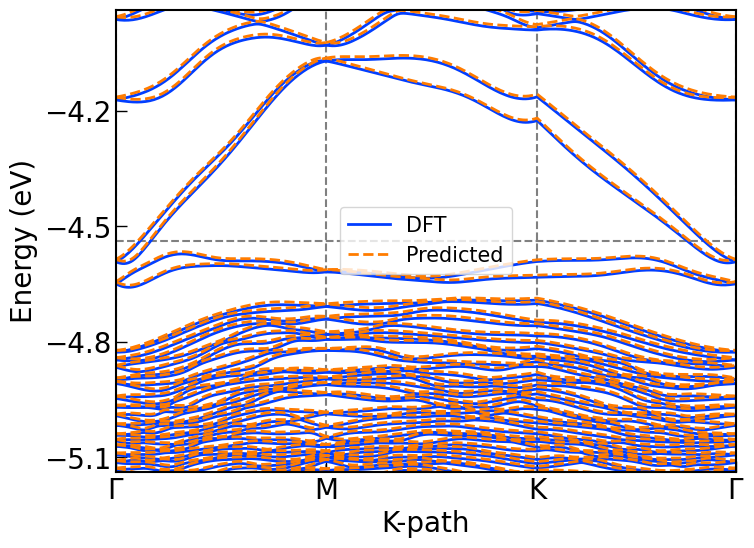

In [214]:
colors = sns.color_palette("bright", 10)
plt.figure(figsize=(8, 6))
bands_true = np.stack(bands_true, axis=0)
for band in bands_true.transpose():
    plt.plot(KPath['x'], band.real, linewidth=2, color=colors[0])
bands_pred = np.stack(bands_pred, axis=0)
for band in bands_pred.transpose():
    plt.plot(KPath['x'], band.real, linewidth=2, linestyle='dashed', color=colors[1])
xticks, xtick_labels = get_xticks_labels(KPath)
plt.xlim([min(xticks), max(xticks)])
plt.xticks(xticks, labels=xtick_labels, fontsize=20)
ax = plt.gca()
for xtick in xticks:
    ax.axvline(x=xtick, color='grey', linestyle='--', linewidth=1.5, zorder=1)
ax.axhline(y=fermi_level, color='grey', linestyle='--', linewidth=1.5, zorder=1)
plt.ylim([fermi_level+d_min,fermi_level+d_max])
resolution = 0.3
yticks =np.arange(np.ceil(ax.get_ylim()[0]/resolution)*resolution, ax.get_ylim()[1], resolution).round(1)
plt.yticks(yticks, fontsize=20)
plt.xlabel('K-path', fontsize=20)
plt.ylabel('Energy (eV)', fontsize=20)
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='DFT'),
                    Line2D([0], [0], color=colors[1], lw=2, linestyle='dashed', label='Predicted')]
plt.legend(handles=legend_elements, fontsize=15)
ax.tick_params(direction='in', length=8, width=1)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.show()

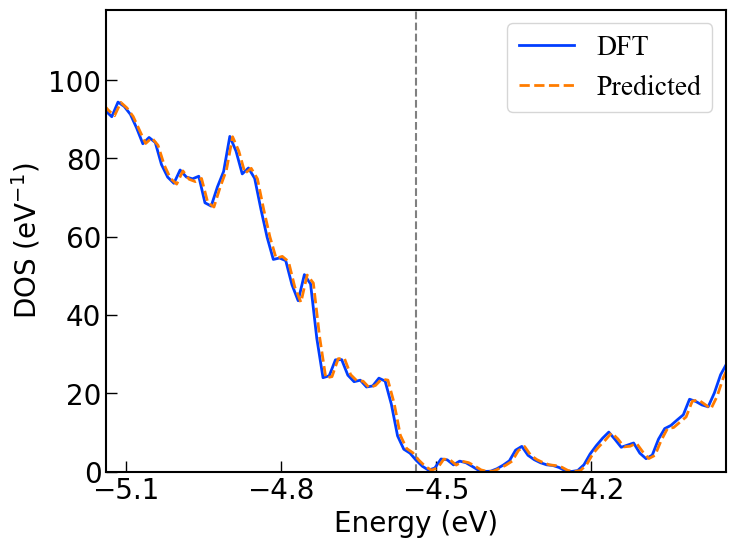

In [217]:
plt.figure(figsize=(8, 6))
plt.plot(energy_centers_true, dos_smoothed_true, linewidth=2, color=colors[0], label="DFT" )
plt.plot(energy_centers_pred, dos_smoothed_pred, linewidth=2, linestyle='dashed', color=colors[1], label='Predicted')
plt.xlim([fermi_level+d_min,fermi_level+d_max])
plt.xticks(yticks, fontsize=20)
ax = plt.gca()
ax.axvline(x=fermi_level, color='grey', linestyle='--', linewidth=1.5, zorder=1)
plt.xlabel('Energy (eV)', fontsize=20)
plt.ylabel(r'DOS (eV$^{-1}$)', fontsize=20)
plt.ylim([0, dos_smoothed_true.max()*1.2])
ax.tick_params(direction='in', length=8, width=1)
plt.yticks(fontsize=20)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
legend_properties = {'family': 'Times New Roman', 'size': 20}
plt.legend(prop=legend_properties)
plt.show()

/home/chem/mssrdn/.conda/envs/DeepH/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



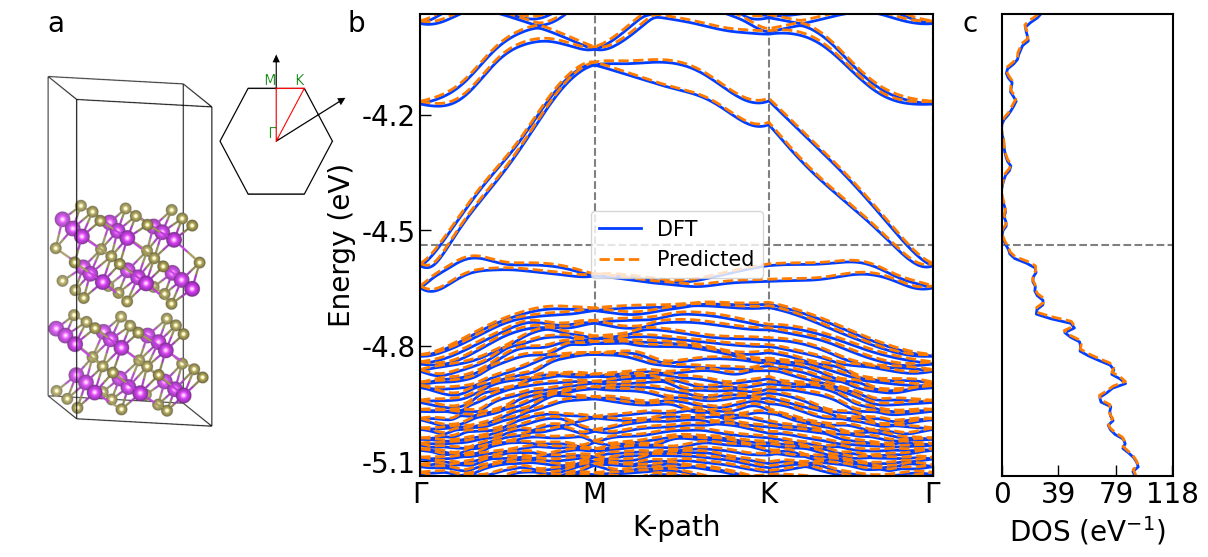

In [213]:
fig, (geo, ax1, ax2) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [2, 3, 1]}, figsize=(15, 6)) #sharedy=True

######################## showing the geometry
image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/72_0.png')
geo.imshow(image[200:1500, 1200:2400])
geo.axis('off')  # Hides the frame around the image
inset_ax = inset_axes(geo, width="80%", height="80%", loc="upper right", 
                      bbox_to_anchor=(0.31, 0.32, 0.8, 0.8), bbox_transform=geo.transAxes)
inset_image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/Brillouin.png')  # Replace with your inset image path
inset_ax.imshow(inset_image, aspect='auto')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_frame_on(False)

######################## plotting band structure 
colors = sns.color_palette("bright", 10)

# Share y-axis explicitly between ax1 and ax2
ax1.sharey(ax2)

bands_true = np.stack(bands_true, axis=0)
for band in bands_true.transpose():
    ax1.plot(KPath['x'], band.real, linewidth=2, color=colors[0])
bands_pred = np.stack(bands_pred, axis=0)
for band in bands_pred.transpose():
    ax1.plot(KPath['x'], band.real, linewidth=2, linestyle='dashed', color=colors[1])
xticks, xtick_labels = get_xticks_labels(KPath)
ax1.set_xlim([min(xticks), max(xticks)])
ax1.set_xticks(xticks, labels=xtick_labels, fontsize=20)
for xtick in xticks:
    ax1.axvline(x=xtick, color='grey', linestyle='--', linewidth=1.5, zorder=1)
ax1.axhline(y=fermi_level, color='grey', linestyle='--', linewidth=1.5, zorder=1)
ax1.set_ylim([fermi_level+d_min,fermi_level+d_max])
resolution = 0.3
ax1_yticks =np.arange(np.ceil(ax1.get_ylim()[0]/resolution)*resolution, ax1.get_ylim()[1], resolution).round(1)
ax1.set_yticks(ax1_yticks) 
ax1.set_yticklabels(ax1_yticks, fontsize=20)
ax1.set_xlabel('K-path', fontsize=20)
ax1.set_ylabel('Energy (eV)', fontsize=20)
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='DFT'),
                    Line2D([0], [0], color=colors[1], lw=2, linestyle='dashed', label='Predicted')]
ax1.legend(handles=legend_elements, fontsize=15)
ax1.tick_params(direction='in', length=8, width=1)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

########################## plotting DOS 

ax2.plot(dos_smoothed_true, energy_centers_true, linewidth=2, color=colors[0], label="DFT" )
ax2.plot(dos_smoothed_pred, energy_centers_pred, linewidth=2, linestyle='dashed', color=colors[1], label='Predicted')
ax2.axhline(y=fermi_level, color='grey', linestyle='--', linewidth=1.5, zorder=1)
ax2.set_xlabel(r'DOS (eV$^{-1}$)', fontsize=20)
ax2.set_xlim([0, dos_smoothed_true.max()*1.2])
ax2.tick_params(direction='in', length=8, width=1)
ax2.set_xticks(np.linspace(0, ax2.get_xlim()[1], 4).round().astype(int), labels=np.linspace(0, ax2.get_xlim()[1], 4).round().astype(int), fontsize=20)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)
ax2.set_ylim([fermi_level+d_min,fermi_level+d_max])
ax2.tick_params(left=False, labelleft=False)

fig.text(0.15, 0.85, "a", fontsize=20, color="black")  
fig.text(0.35, 0.85, "b", fontsize=20, color="black")  
fig.text(0.76, 0.85, "c", fontsize=20, color="black")  

plt.show()

In [31]:
np.arange(np.ceil(ax1.get_ylim()[0]), ax1.get_ylim()[1]+0.001, 1.)

array([-6., -5., -4., -3., -2., -1.])

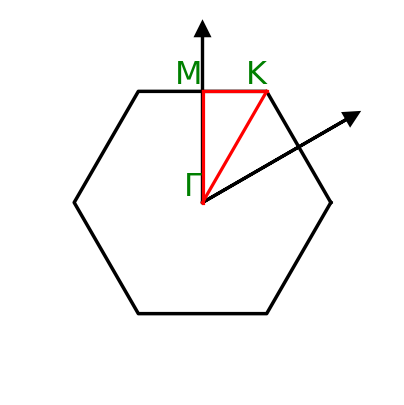

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate hexagon vertices
def hexagon_vertices(center, radius):
    angles = np.linspace(0, 2 * np.pi, 7)
    return np.array([center[0] + radius * np.cos(angles), center[1] + radius * np.sin(angles)])

# Define hexagon properties
center = (0, 0)
radius = 1

# Compute hexagon vertices
hexagon = hexagon_vertices(center, radius)

# Define points P, K, M
G = center
K = hexagon[:, 1]  # A vertex of the hexagon
M = (K + hexagon[:, 2]) / 2  # Midpoint of an edge

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

# Plot hexagon
ax.plot(hexagon[0], hexagon[1], 'k-', linewidth=2.5)

# Plot vectors in red
ax.plot([G[0], K[0]], [G[1], K[1]], 'r-', linewidth=2.3)
ax.plot([G[0], M[0]], [G[1], M[1]], 'r-', linewidth=2.3)
ax.plot([K[0], M[0]], [K[1], M[1]], 'r-', linewidth=2.3)

# Add arrows to indicate coordinate axes
ax.arrow(0, 0, 0, 1.3, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2.3)
ax.arrow(0, 0, 1.3 / ( 2 / 1.732), 1.3 / 2, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2.3)

# Annotate points
ax.text(G[0], G[1], r'$\Gamma$', fontsize=23, color='green', verticalalignment='bottom', horizontalalignment='right')
ax.text(K[0], K[1], 'K', fontsize=23, color='green', verticalalignment='bottom', horizontalalignment='right')
ax.text(M[0], M[1], 'M', fontsize=23, color='green', verticalalignment='bottom', horizontalalignment='right')

# Adjust limits and aspect
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

fig.savefig("/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/Brillouin.png", dpi=300, transparent=True)
plt.show()

In [105]:
atoms.write(os.path.join(data_dir, "POSCAR"), format='vasp')

(-0.5, 1199.5, 1299.5, -0.5)

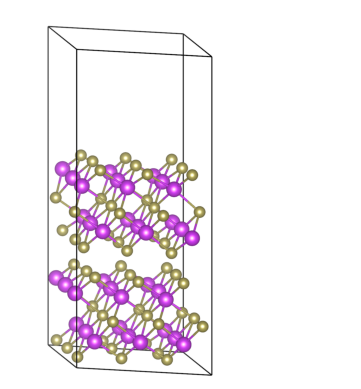

In [119]:
image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/72_0.png')
image.shape
plt.imshow(image[200:1500, 1200:2400])
plt.axis('off')

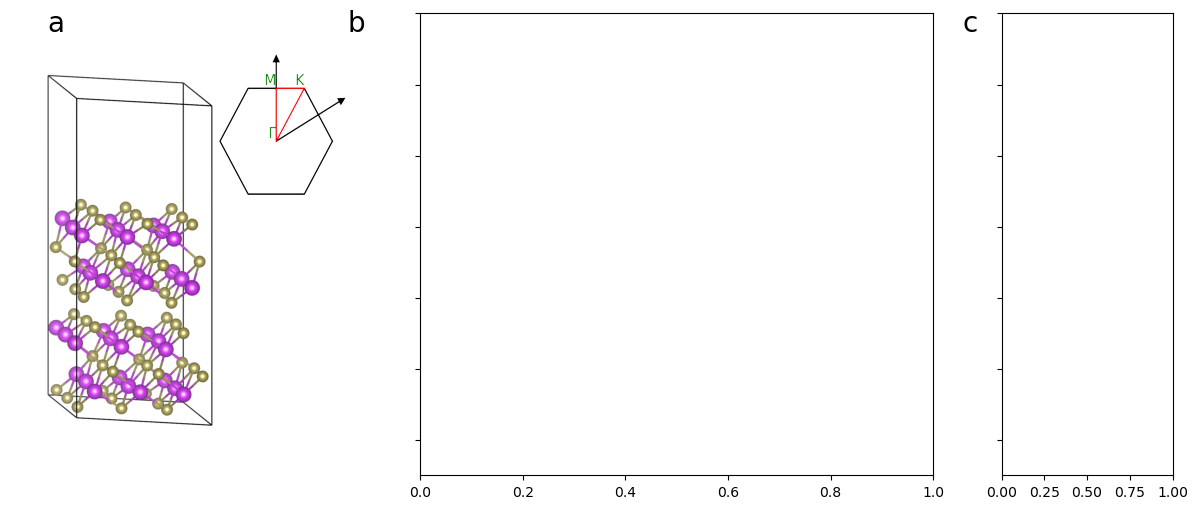

In [211]:
fig, (geo, ax1, ax2) = plt.subplots(ncols=3, sharey=True, gridspec_kw={'width_ratios': [2, 3, 1]}, figsize=(15, 6))

######################## showing the geometry
image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/72_0.png')
geo.imshow(image[200:1500, 1200:2400])  # Hides the frame around the image
geo.axis("off")
inset_ax = inset_axes(geo, width="80%", height="80%", loc="upper right", 
                      bbox_to_anchor=(0.31, 0.32, 0.8, 0.8), bbox_transform=geo.transAxes)
inset_image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/Brillouin.png')  # Replace with your inset image path
inset_ax.imshow(inset_image, aspect='auto')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_frame_on(False)  # Keep the frame for visibility (optional)

# image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/72_0.png')
# geo.imshow(image[200:1500, 1200:2400])
# geo.axis('off')  # Hides the frame around the image
# inset_ax = inset_axes(geo, width="80%", height="80%", loc="upper right", 
#                       bbox_to_anchor=(0.31, 0.32, 0.8, 0.8), bbox_transform=geo.transAxes)
# inset_image = mpimg.imread('/home/chem/mssrdn/MyData/MACE-H/Band_Structure/subfigs/Brillouin.png')  # Replace with your inset image path
# inset_ax.imshow(inset_image, aspect='auto')
# inset_ax.set_xticks([])
# inset_ax.set_yticks([])
# inset_ax.set_frame_on(False)

fig.text(0.15, 0.85, "a", fontsize=20, color="black")  
fig.text(0.35, 0.85, "b", fontsize=20, color="black")  
fig.text(0.76, 0.85, "c", fontsize=20, color="black")  

plt.show()

-3